In [1]:
# download from figshare from scIB
import os, sys, time
HOMEDIR = os.path.expanduser("~")
PROJDIR = rf"{HOMEDIR}/G-scIB_dev"
sys.path.append(rf"{PROJDIR}/src")

import Data_Handler as dh, Utils_Handler as uh, Vis_Handler as vh
import umap, numpy as np, pandas as pd, scanpy as sc
from scipy.sparse import diags
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.settings.verbosity = 3 # 3

In [2]:
adata = sc.read_h5ad(dh.DATA_EMB_["pancreas"])
obsm_keys = list(adata.obsm)
for embed in obsm_keys:
    print("%12s, %d" % (embed, adata.obsm[embed].shape[1]))
    assert adata.obsm[embed].shape[0] == np.unique(adata.obsm[embed], axis=0).shape[0]

     Harmony, 50
    Islander, 16
   Scanorama, 100
     X_bbknn, 2
       X_pca, 50
    X_scANVI, 30
      X_scVI, 30
      X_tsne, 2
      X_umap, 2
      scPoli, 10


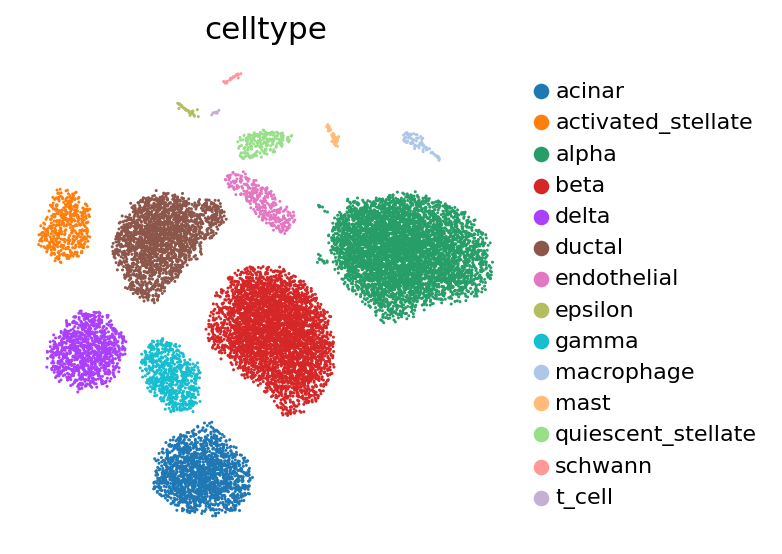

In [3]:
_obsm = "Islander"
dataset = "pancreas"
reducer = umap.UMAP(min_dist=1.0)
embedding = reducer.fit_transform(adata.obsm[_obsm])
adata.obsm["%s_UMAP" % _obsm] = embedding

sc.pl.embedding(
    adata,
    basis="%s_UMAP" % _obsm,
    color=[dh.META_[dataset]["celltype"]],  
    **vh.cfg
)

In [4]:
adata.write(dh.DATA_EMB_["pancreas"], compression="gzip")

In [3]:
sc.pp.highly_variable_genes(adata, subset=True, flavor="seurat_v3", n_top_genes=1000)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 16382 × 1000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', 'conditions_combined'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors', 'tech_colors', 'tsne', 'umap', 'hvg'
    obsm: 'Harmony', 'Scanorama', 'X_bbknn', 'X_pca', 'X_scANVI', 'X_scVI', 'X_tsne', 'X_umap', 'scPoli'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata.write(rf"{dh.DATA_DIR}/pancreas/emb_hvg.h5ad", compression="gzip")

### Process the Raw

In [3]:
# adata = sc.read_h5ad(rf"{dh.DATA_DIR}/Pancreas/pancreas_sparse.h5ad")
adata = sc.read_h5ad(rf"{dh.DATA_DIR}/Pancreas/human_pancreas_norm_complexBatch.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [6]:
adata.obs["tech"].unique()

['celseq', 'celseq2', 'fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter']
Categories (9, object): ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', ..., 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']

In [7]:
adata.obs["tech"].index.unique()

Index(['D101_5', 'D101_43', 'D101_93', 'D102_4', 'D172444_23', 'D172444_68',
       'D17All1_2', 'D17All1_18', 'D17All1_28', 'D17All1_72',
       ...
       'Sample_1589', 'Sample_1590', 'Sample_1591', 'Sample_1592',
       'Sample_1593', 'Sample_1594', 'Sample_1595', 'Sample_1597',
       'Sample_1598', 'Sample_1600'],
      dtype='object', length=16382)

In [8]:
n_neighbors=10
n_pcs=50

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
sc.tl.umap(adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:01:17)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [9]:
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

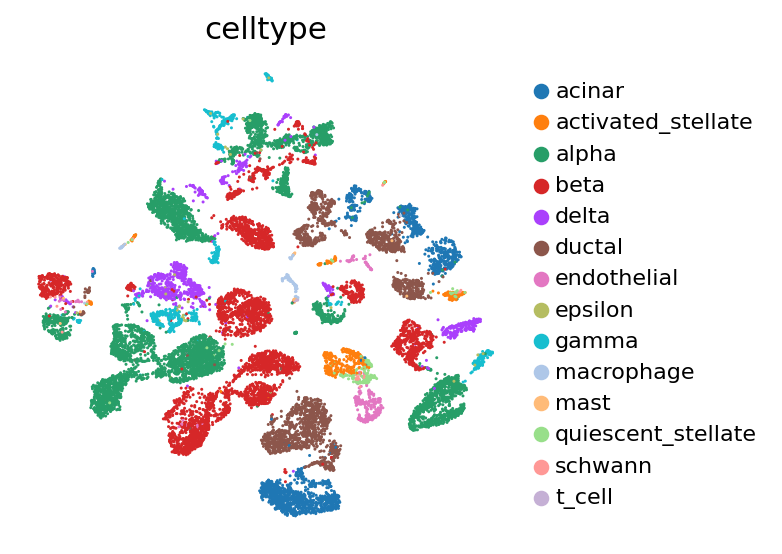

In [11]:
sc.pl.embedding(adata, basis="X_umap", color=["celltype"], **vh.cfg)

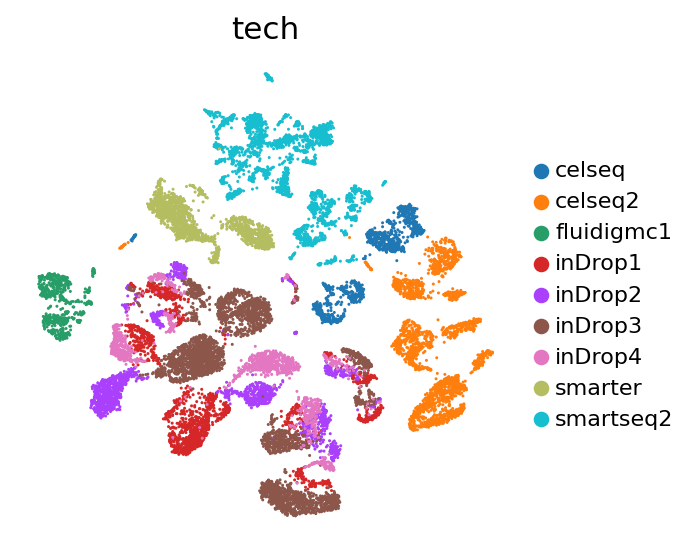

In [12]:
sc.pl.embedding(adata, basis="X_umap", color=["tech"], **vh.cfg)

In [13]:
adata.write(dh.DATA_EMB_["pancreas"], compression="gzip")

### Save the Metadata

In [2]:
adata = sc.read_h5ad(dh.DATA_EMB_["pancreas"])

In [3]:
os.makedirs(rf"{dh.META_DIR}/pancreas/", exist_ok=True)

In [ ]:
import json
CELL2CAT = dict()
for idx, batch in enumerate(adata.obs["celltype"].unique()):
    CELL2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/pancreas/cell2cat.json", "w")
_file.write(json.dumps(CELL2CAT))
_file.close()

BATCH2CAT = dict()
for idx, batch in enumerate(adata.obs["tech"].unique()):
    BATCH2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/pancreas/batch2cat.json", "w")
_file.write(json.dumps(BATCH2CAT))
_file.close()

### Below is Deprecated

In [11]:
adata.layers["counts"]

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.0019583,  0.       ,  0.       , ...,  0.       ,  1.001958 ,
         0.       ],
       [ 0.       ,  1.0019583,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.5372   , 12.7441   ,  0.       , ...,  7.2688   ,  1.9903   ,
         1.8303   ],
       [31.1225   ,  0.9078   ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.5788   ,  0.6753   ,  0.       , ...,  0.       ,  0.7148   ,
         0.       ]], dtype=float32)

In [12]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.6120808 , 0.        , 0.        , ..., 0.        , 2.6120806 ,
        0.        ],
       [0.        , 3.311074  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.42996258, 2.6206095 , 0.        , ..., 2.1124895 , 1.0953737 ,
        1.0403827 ],
       [3.4695568 , 0.64595073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4566651 , 0.5159923 , 0.        , ..., 0.        , 0.53929645,
        0.        ]], dtype=float32)

In [14]:
size_factors = adata.obs["size_factors"]

adata.X = np.expm1(adata.X)
# Step 2: Reverse normalization using size_factors
scaling_matrix = diags(size_factors)  # Create a diagonal matrix with size_factors
adata.X = scaling_matrix.dot(adata.X)  # Matrix multiplication

In [15]:
adata.X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.00195826,  0.        ,  0.        , ...,  0.        ,
         1.00195804,  0.        ],
       [ 0.        ,  1.00195843,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.53719997, 12.74409866,  0.        , ...,  7.26880074,
         1.99030006,  1.83030009],
       [31.12250328,  0.90779996,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57880008,  0.67530006,  0.        , ...,  0.        ,
         0.7148    ,  0.        ]])

In [17]:
adata.layers["counts"].sum(axis=0)

array([ 66088.84 , 158814.88 ,  41669.016, ..., 102418.79 ,  78946.55 ,
        67860.89 ], dtype=float32)

In [21]:
np.expm1(adata.layers["counts"]).sum(axis=1)

/home/wangh256/scratch/tmp/ipykernel_791558/3259889998.py:1: RuntimeWarning: overflow encountered in expm1
  np.expm1(adata.layers["counts"]).sum(axis=1)


array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

In [ ]:
# Assume you have size_factors for each cell
# (Replace this with your actual size_factors)
size_factors = np.random.rand(adata.shape[0])
# Forward Transformations
adata.X /= size_factors[:, None]  # Divide by size_factors
sc.pp.log1p(adata)
# Reverse Transformations
# Step 1: Reverse log1p, exp(x) - 1
adata.X = np.expm1(adata.X)
# Step 2: Reverse normalization using size_factors
scaling_matrix = diags(size_factors)  # Create a diagonal matrix with size_factors
adata.X = scaling_matrix.dot(adata.X)  # Matrix multiplication
# Check if adata.X and bdata.X are approximately equal
# Using np.isclose to account for possible floating point errors
comparison_result = np.isclose(adata.X.toarray(), bdata.X.toarray()) if isinstance(adata.X, scipy.sparse.spmatrix) else np.isclose(adata.X, bdata.X)
print("Are the matrices approximately equal?: ", np.all(comparison_result))

In [ ]:
# Store the counts per cell before reversing normalization
counts_per_cell = np.sum(adata.X, axis=1)
# Reverse Transformations
# Step 1: Reverse log1p, which is exp(x) - 1
adata.X = np.expm1(adata.X)
# Step 2: Reverse per-cell normalization
for i in range(adata.shape[0]):
    adata.X[i, :] *= counts_per_cell[i] / 1e4  # Reverse to original scale
# Now, adata should be approximately back to its original state

In [50]:
normed_counts = np.exp(adata.X.toarray()) - 1
size_factors = 1e4 / adata.obs["size_factors"].values
np.log(normed_counts * size_factors[:, None] + 1)

KeyError: 'size_factors'

In [3]:
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [22]:
adata.layers['counts']

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.0019583,  0.       ,  0.       , ...,  0.       ,  1.001958 ,
         0.       ],
       [ 0.       ,  1.0019583,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.5372   , 12.7441   ,  0.       , ...,  7.2688   ,  1.9903   ,
         1.8303   ],
       [31.1225   ,  0.9078   ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.5788   ,  0.6753   ,  0.       , ...,  0.       ,  0.7148   ,
         0.       ]], dtype=float32)

In [7]:
uh.norm2count(adata.X)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6651859 , 0.        , 0.        , ..., 0.        , 0.6651858 ,
        0.        ],
       [0.        , 1.110486  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0127058 , 0.26493496, 0.        , ..., 0.1595802 , 0.04628689,
        0.04264402],
       [0.56391454, 0.02185581, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01260811, 0.01469479, 0.        , ..., 0.        , 0.01554761,
        0.        ]], dtype=float32)

In [9]:
adata.X.shape

(16382, 19093)

In [6]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.6120808 , 0.        , 0.        , ..., 0.        , 2.6120806 ,
        0.        ],
       [0.        , 3.311074  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.42996258, 2.6206095 , 0.        , ..., 2.1124895 , 1.0953737 ,
        1.0403827 ],
       [3.4695568 , 0.64595073, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4566651 , 0.5159923 , 0.        , ..., 0.        , 0.53929645,
        0.        ]], dtype=float32)

In [11]:
adata.var

""
A1BG
A1CF
A2M
A2ML1
A4GALT
...
ZXDC
ZYG11B
ZYX
ZZEF1


In [15]:
size_factors.shape

(16382,)

In [24]:
adata.layers['counts']

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.0019583,  0.       ,  0.       , ...,  0.       ,  1.001958 ,
         0.       ],
       [ 0.       ,  1.0019583,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.5372   , 12.7441   ,  0.       , ...,  7.2688   ,  1.9903   ,
         1.8303   ],
       [31.1225   ,  0.9078   ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.5788   ,  0.6753   ,  0.       , ...,  0.       ,  0.7148   ,
         0.       ]], dtype=float32)

In [25]:
adata.layers['counts'].shape

(16382, 19093)

In [32]:
np.expm1(adata.layers['counts'])

/home/wangh256/scratch/tmp/ipykernel_977245/118589829.py:1: RuntimeWarning: overflow encountered in expm1
  np.expm1(adata.layers['counts'])


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.7236102e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.7236094e+00, 0.0000000e+00],
       [0.0000000e+00, 1.7236102e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [7.1120870e-01, 3.4252388e+05, 0.0000000e+00, ..., 1.4338274e+03,
        6.3177290e+00, 5.2357569e+00],
       [3.2834452e+13, 1.4788631e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8389651e-01, 9.6462226e-01, 0.0000000e+00, ..., 0.0000000e+00,
        1.0437779e+00, 0.0000000e+00]], dtype=float32)

In [37]:
# Assuming adata is your data object and size_factors is the array of size factors
size_factors = adata.obs['size_factors'].values
# Reverse the normalization
_counts = (adata.layers['counts'] * 1e4) / size_factors[:, np.newaxis]
# Now reverse the log1p transformation
np.expm1(_counts)

/home/wangh256/scratch/tmp/ipykernel_977245/2736883318.py:6: RuntimeWarning: overflow encountered in expm1
  np.expm1(_counts)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [inf,  0.,  0., ...,  0., inf,  0.],
       [ 0., inf,  0., ...,  0.,  0.,  0.],
       ...,
       [inf, inf,  0., ..., inf, inf, inf],
       [inf, inf,  0., ...,  0.,  0.,  0.],
       [inf, inf,  0., ...,  0., inf,  0.]])

In [42]:
normed_counts = np.expm1(adata.layers['counts'])
(normed_counts * 1e4) / adata.obs["size_factors"].values[:, np.newaxis]

/home/wangh256/scratch/tmp/ipykernel_977245/2910979284.py:1: RuntimeWarning: overflow encountered in expm1
  normed_counts = np.expm1(adata.layers['counts'])
/home/wangh256/scratch/tmp/ipykernel_977245/2910979284.py:2: RuntimeWarning: overflow encountered in multiply
  (normed_counts * 1e4) / adata.obs["size_factors"].values[:, np.newaxis]


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.17221384e+05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.17221286e+05, 0.00000000e+00],
       [0.00000000e+00, 4.54394046e+05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.11208691e+03, 3.42523878e+09, 0.00000000e+00, ...,
        1.43382740e+07, 6.31772891e+04, 5.23575703e+04],
       [3.28344512e+17, 1.47886309e+04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.83896484e+03, 9.64622266e+03, 0.00000000e+00, ...,
        0.00000000e+00, 1.04377793e+04, 0.00000000e+00]])

In [30]:
adata.X

array([[nan, nan, nan, ..., nan, nan, nan],
       [inf, nan, nan, ..., nan, inf, nan],
       [nan, inf, nan, ..., nan, nan, nan],
       ...,
       [inf, inf, nan, ..., inf, inf, inf],
       [inf, inf, nan, ..., nan, nan, nan],
       [inf, inf, nan, ..., nan, inf, nan]], dtype=float32)

In [41]:
normed_counts = np.exp(adata.layers['counts']) - 1
size_factors = 1e6 / adata.obs["size_factors"].values
np.log(normed_counts * size_factors[:, None] + 1)

/home/wangh256/scratch/tmp/ipykernel_977245/2829741299.py:1: RuntimeWarning: overflow encountered in exp
  normed_counts = np.exp(adata.layers['counts']) - 1


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [16.89384255,  0.        ,  0.        , ...,  0.        ,
        16.89384214,  0.        ],
       [ 0.        , 17.63189026,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [13.47472277, 26.55960729,  0.        , ..., 21.08361312,
        15.65887052, 15.47102216],
       [44.93801002, 14.20678478,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [13.57203363, 13.77949302,  0.        , ...,  0.        ,
        13.85835806,  0.        ]])

In [28]:
normed_counts = np.exp(adata.layers['counts']) - 1
size_factors = 1e4 / adata.obs["size_factors"].values
np.log(normed_counts * size_factors[:, None] + 1)

/home/wangh256/scratch/tmp/ipykernel_977245/1030785071.py:1: RuntimeWarning: overflow encountered in exp
  normed_counts = np.exp(adata.layers['counts']) - 1


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [12.28867692,  0.        ,  0.        , ...,  0.        ,
        12.28867651,  0.        ],
       [ 0.        , 13.02672225,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 8.86969177, 21.95443711,  0.        , ..., 16.478443  ,
        11.05371601, 10.86587088],
       [40.33283983,  9.60168154,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 8.96698973,  9.17442546,  0.        , ...,  0.        ,
         9.25328271,  0.        ]])

In [19]:
normed_counts = adata.X
size_factors = 1e4 / adata.obs["size_factors"].values
np.log(normed_counts * size_factors[:, None] + 1)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [12.70440148,  0.        ,  0.        , ...,  0.        ,
        12.70440139,  0.        ],
       [ 0.        , 13.67957278,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 8.36651582, 10.17378546,  0.        , ...,  9.9582548 ,
         9.30152729,  9.25002515],
       [10.45439606,  8.77346313,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 8.42675434,  8.54887069,  0.        , ...,  0.        ,
         8.59303592,  0.        ]])

In [12]:
adata.obs

,tech,celltype,size_factors
D101_5,celseq,gamma,0.028492
D101_43,celseq,gamma,0.079348
D101_93,celseq,gamma,0.037932
D102_4,celseq,gamma,0.047685
D172444_23,celseq,gamma,0.038683
...,...,...,...
Sample_1594,smarter,gamma,1.000000
Sample_1595,smarter,gamma,1.000000
Sample_1597,smarter,gamma,1.000000
Sample_1598,smarter,gamma,1.000000


    Highly expressive genes

    Apply basic filtering (quality control) -> no drops

    with pre-computed UMAP coordinates

In [29]:
os.makedirs("../res/umap", exist_ok=True)

/home/hanchen/anaconda3/envs/genemetric/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


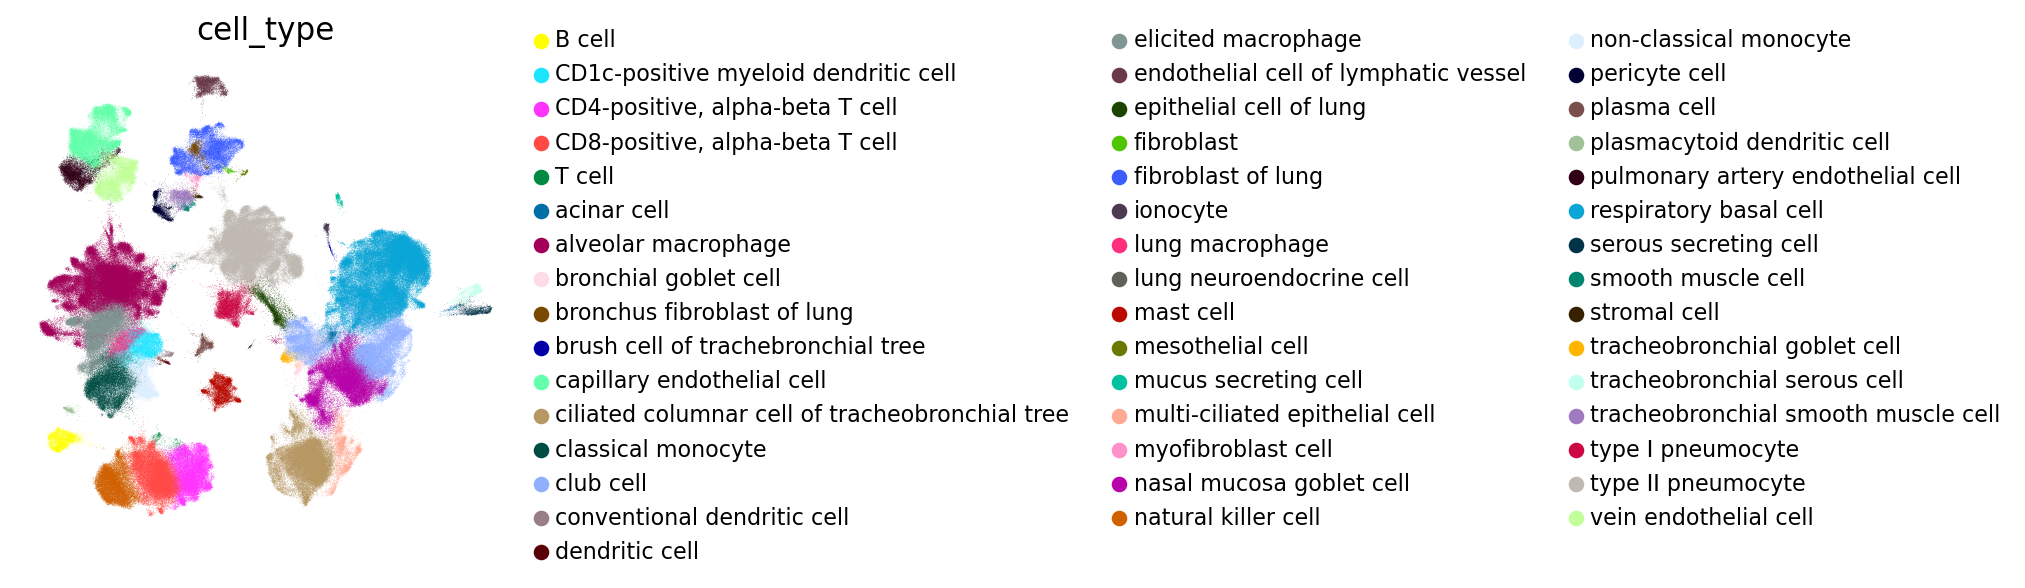

In [30]:
sc.pl.umap(
    adata,
    color="cell_type",
    frameon=False,
    legend_fontsize=10,
    legend_fontoutline=2,
    save="_integrated_celltype",
)
os.rename("figures/umap_integrated_celltype.pdf", "../res/umap/integrated_celltype.pdf")